# Generate fieldmaps using topup

Given spin-echo EPI images with opposite phase encoding directions, this example code creates fieldmaps that can be used to correct geometrical distortions in EPI sequences like dwi or BOLD fmri.

Has been tested on sequences used on GE Signa PET/MR (UPC project) and Philips Achieva 3T (MCT-minus project).

The code is written to run in Neurodesktop.

In [1]:
#load FSL
import lmod
import os
import json
from nilearn import plotting
import nibabel as nib
from matplotlib import pyplot as plt
await lmod.load('fsl/6.0.5.1')
await lmod.list()
os.environ["FSLDIR"]="/cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.5.1_20221016/fsl_6.0.5.1_20221016.simg/opt/fsl-6.0.5.1/"
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"
os.environ["SINGULARITY_BINDPATH"]="/data,/neurodesktop-storage,/tmp,/cvmfs"

In [2]:
#User defined
datadir='/data/argos/Gold/UPC/MCT-studien/MR-pilot/mct/nifti'
APfile=os.path.join(datadir,'fMRI_geoCorr_blipDown.nii.gz')
PAfile=os.path.join(datadir,'fMRI_geoCorr_blipUp.nii.gz')
method='Philips'
prefix='fMRI' #prefix for output files

In [3]:
#define variables
ext='.nii.gz'
outdir=os.path.join(datadir,'fieldmap')
os.makedirs(outdir,exist_ok=True)
params=os.path.join(outdir,'params')
APPAfile=os.path.join(outdir,'APPA')
outfile=os.path.join(outdir,prefix)
if method=='GE':
    config='b02b0_1.cnf'
    key='TotalReadoutTime'
elif method=='Philips':
    config='b02b0.cnf'
    key='EstimatedTotalReadoutTime'

#get parameter from json sidecar
jfile=open(APfile.split('.nii')[0] + '.json','r')
p=json.loads(jfile.read())
jfile.close()

In [4]:
%%bash -s "{p[key]}" "$params"
#create parameter file
echo "0 -1 0 $1" > $2
echo "0 1 0 $1" >> $2

In [5]:
#get last frame from each phase encoding dir and merge
AP=nib.load(APfile)
PA=nib.load(PAfile)
AP=AP.slicer[...,-1]
PA=PA.slicer[...,-1]
APPA=nib.concat_images((AP,PA))
nib.save(APPA, APPAfile+ext)

## Check your input images

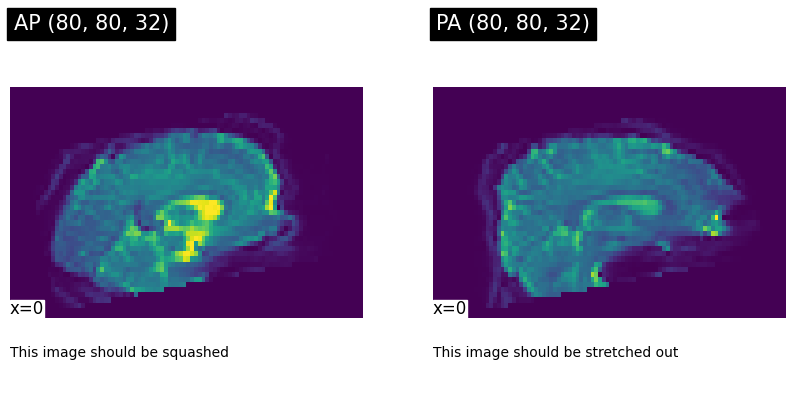

In [6]:
fig,ax=plt.subplots(ncols=2,figsize=(10,5))
plotting.plot_img(AP,display_mode='x',cut_coords=[0],axes=ax[0],title='AP '+str(AP.shape))
plotting.plot_img(PA,display_mode='x',cut_coords=[0],axes=ax[1],title='PA '+str(PA.shape))
ax[0].text(0,.1,'This image should be squashed')
ax[1].text(0,.1,'This image should be stretched out')
fig.show()

In [7]:
#generate fieldmap
!topup --imain={APPAfile} --datain={params} --config={config} --out={outfile} --fout={outfile+'_field'} --iout={outfile+'_unwarped'}
!cat {APPAfile+'.topup_log'}
os.remove(APPAfile+ext)

# 	name of 4D file with images
--imain=/data/argos/Gold/UPC/MCT-studien/MR-pilot/mct/nifti/fieldmap/APPA.nii.gz
# name of text file with PE directions/times
--datain=/data/argos/Gold/UPC/MCT-studien/MR-pilot/mct/nifti/fieldmap/params
# 	base-name of output files (spline coefficients (Hz) and movement parameters)
--out=/data/argos/Gold/UPC/MCT-studien/MR-pilot/mct/nifti/fieldmap/fMRI
# 	name of image file with field (Hz)
--fout=/data/argos/Gold/UPC/MCT-studien/MR-pilot/mct/nifti/fieldmap/fMRI_field
# 	name of 4D image file with unwarped images
--iout=/data/argos/Gold/UPC/MCT-studien/MR-pilot/mct/nifti/fieldmap/fMRI_unwarped
# (approximate) resolution (in mm) of warp basis for the different sub-sampling levels, default 10
--warpres=20,16,14,12,10,6,4,4,4
# sub-sampling scheme, default 1
--subsamp=2,2,2,2,2,1,1,1,1
# 	FWHM (in mm) of gaussian smoothing kernel, default 8
--fwhm=8,6,4,3,3,2,1,0,0
# 	Max # of non-linear iterations, default 5
--miter=5,5,5,5,5,10,10,20,20
# Weight of regulari

## Check your results

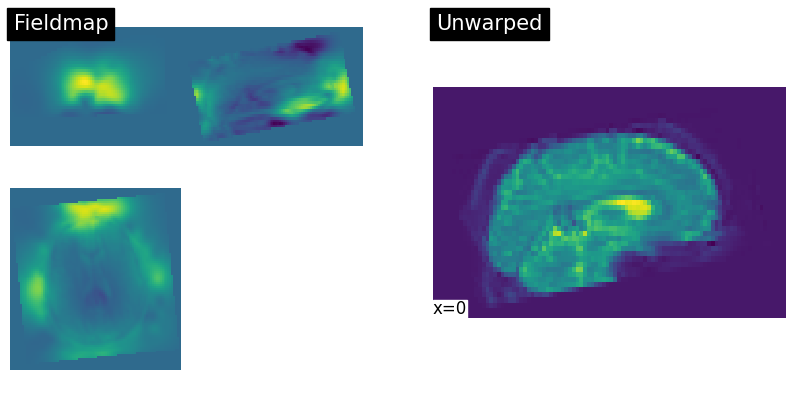

In [8]:
field=nib.load(outfile+'_field.nii.gz')
unwarped=nib.load(outfile+'_unwarped.nii.gz')
unwarped=unwarped.slicer[...,-1]

fig,ax=plt.subplots(ncols=2,figsize=(10,5))
plotting.plot_img(field,display_mode='tiled',axes=ax[0],title='Fieldmap',annotate=False,draw_cross=False)
plotting.plot_img(unwarped,display_mode='x',cut_coords=[0],axes=ax[1],title='Unwarped')